In [88]:
import pandas as pd
import numpy as np

首先导入ground_truth数据

In [89]:
gt = 'gt/1.csv'
GT = pd.read_csv(gt).iloc[:, [2, 3, -1]]

Lat = np.array(GT.iloc[:, 0])
Log = np.array(GT.iloc[:, 1])
RefTime = np.array(GT.iloc[:, 2])
# print(RefTime.shape)

然后导入gnss数据

In [90]:
road = 'gnss/1.csv'
Road = pd.read_csv(road).iloc[:, [1, -3, -2, -1]]
# Road = Road.drop_duplicates(subset='utcTimeMillis')

RawX = np.array(Road.iloc[:, 1])
RawY = np.array(Road.iloc[:, 2])
RawZ = np.array(Road.iloc[:, 3])
RawTime = np.array(Road.iloc[:, 0])
# print(RawTime.shape)

将ground_truth转换为xyz坐标

In [91]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

In [92]:
Alt = np.zeros_like(Log)
h = 100
Alt += h
RefX, RefY, RefZ = WGS84_to_ECEF(Lat, Log, Alt)

开始计算误差

In [93]:
ref = 0
error = np.zeros_like(RawTime)
for i in range(RawTime.shape[0]):
    # 找到对应时间戳
    for j in range(ref, RefTime.shape[0]):
        if abs(RawTime[i] - RefTime[j]) < 1000:
            ref = j
            break

    # 计算误差
    error[i] = np.sqrt(
        (RawX[i] - RefX[ref]) ** 2 + (RawY[i] - RefY[ref]) ** 2 + (RawZ[i] - RefZ[ref]) ** 2
    )

制图

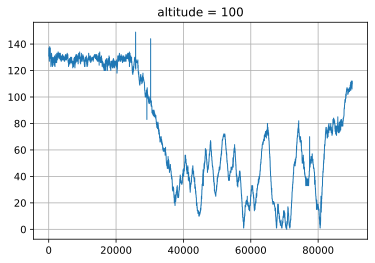

In [94]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='svg'

plt.plot(error, linewidth=1)
plt.grid(True)
plt.title('altitude = {}'.format(h))
plt.show()